In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.neural_network import MLPClassifier

In [2]:
combined_df = pd.read_csv('data/combined.csv')
ratio_df = pd.read_csv('data/ratio_df.csv')
cashflow_df = pd.read_csv('data/cashflow_df.csv')
growth_df = pd.read_csv('data/growth_df.csv')

# Appraisal methods:

1. Predict next year's net profit/loss position (netIncomeGrowth)
2. Dividend prediction (dividendPayoutRatio, dividendYield)

Most important: Selecting relevant columns (not redundant)
Absolute figures: not the best since y-axis is rate, not absolute figure

In [3]:
# --- Selecting columns for prediction
y_axis = ['netIncomeGrowth', 'epsgrowth', 'dividendsperShareGrowth', 'threeYNetIncomeGrowthPerShare', 'fiveYNetIncomeGrowthPerShare']
growth_df = growth_df[growth_df['quarter'] >= -3]
growth_df = growth_df[['symbol', 'quarter'] + y_axis]
growth_df.head()


,symbol,quarter,netIncomeGrowth,epsgrowth,dividendsperShareGrowth,threeYNetIncomeGrowthPerShare,fiveYNetIncomeGrowthPerShare
0,CMCSA,81,-0.015089,-0.010687,0.022359,0.094183,0.673132
1,CMCSA,80,0.674096,0.672761,-0.004576,-0.767501,0.858378
2,CMCSA,79,-0.324297,-0.319870,0.013258,-0.202413,0.105891
3,CMCSA,78,0.391709,0.394736,0.078077,0.237213,0.536314
4,CMCSA,77,-0.320999,-0.320265,0.022004,-0.126708,0.154534


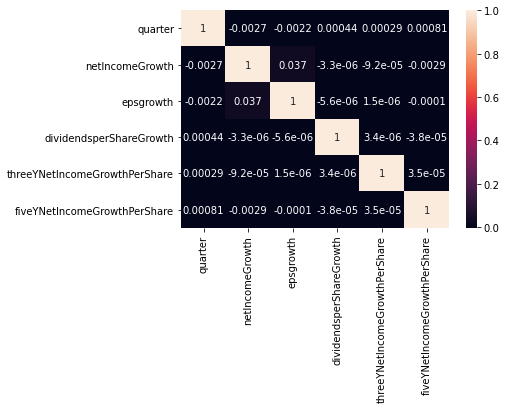

In [137]:
sns.heatmap(growth_df.corr(), annot=True)
plt.show()

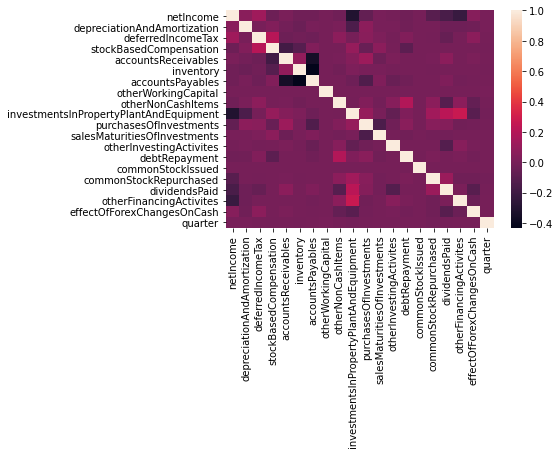

In [4]:
drop_list = ['Unnamed: 0', 'date','reportedCurrency','fillingDate','acceptedDate','period','changeInWorkingCapital','netCashProvidedByOperatingActivities','acquisitionsNet','netCashUsedForInvestingActivites','netCashUsedProvidedByFinancingActivities','netChangeInCash','cashAtEndOfPeriod','cashAtBeginningOfPeriod','operatingCashFlow','capitalExpenditure','freeCashFlow','link','finalLink','year']

cashflow_df = cashflow_df[cashflow_df['quarter'] >= -3]
figures = cashflow_df.drop(columns=drop_list)
sns.heatmap(figures.corr())
plt.show()

USA GDP growth rate: (for reference)
12/31/2001	0.9983
12/31/2002	1.7417
12/31/2003	2.8612
12/31/2004	3.7989
12/31/2005	3.5132
12/31/2006	2.855
12/31/2007	1.8762
12/31/2008	-0.1366
12/31/2009	-2.5368
12/31/2010	2.5638
12/31/2011	1.5508
12/31/2012	2.2495
12/31/2013	1.8421
12/31/2014	2.526
12/31/2015	3.0755
12/31/2016	1.7114
12/31/2017	2.3327
12/31/2018	2.9965
12/31/2019	2.1612
12/31/2020	-3.4861

Average = 1.724725

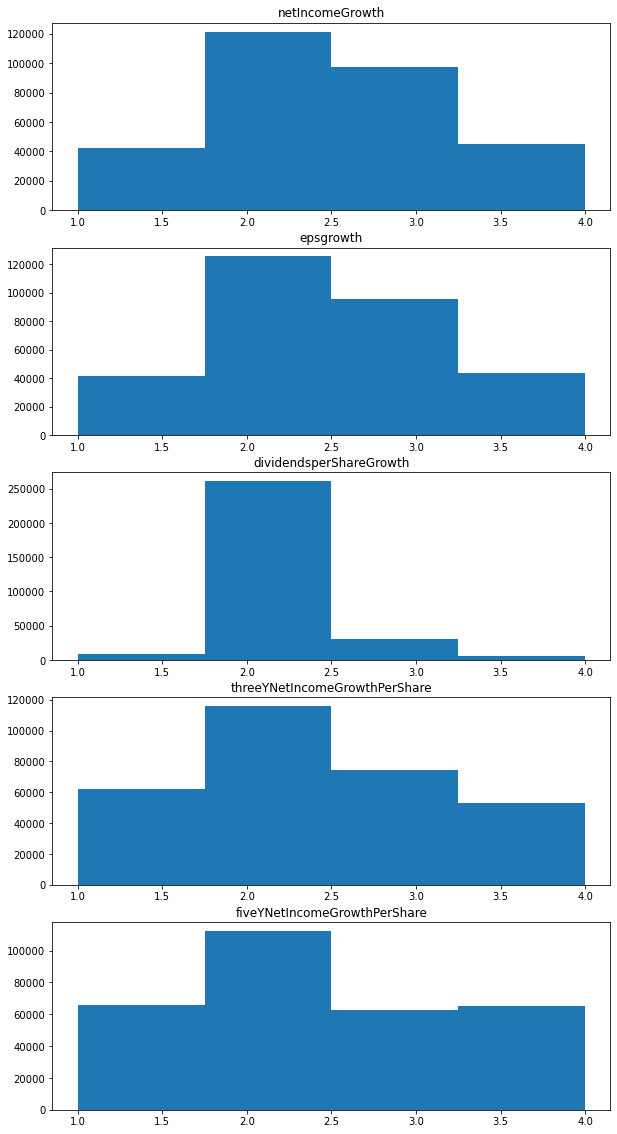

In [5]:
# --- Classification of rate
########## Subject to review ############

def growth(n):
    if type(n) == float:
        if n <= -1:
            return 1
        elif n <= 0.01724725:
            return 2
        elif n <= 1:
            return 3
        else:
            return 4
    else:
        return n

growth_df_cla = growth_df.applymap(growth)

# --- Distribution of data

fig, axs = plt.subplots(5)
fig.set_size_inches(10, 20)
k = 0
for i in y_axis:
    axs[k].hist(growth_df_cla[i], bins = 4)
    axs[k].set_title(i)
    k += 1
plt.show()

In [6]:
combined = pd.merge(figures, growth_df_cla, on=['symbol', 'quarter'])
a = combined.pop('quarter')
combined.insert(1,'quarter',a)


In [7]:
# --- Shifting one quarter back for prediction purpose
combined.insert(2, 'quarter_pred', combined['quarter'] - 1)
combined_2 = combined[['symbol','quarter_pred']+y_axis]
combined_2 = combined_2.rename({'quarter_pred': 'quarter'}, axis = 1)
combined = pd.merge(combined, combined_2, on=['symbol', 'quarter'])
combined.head()

,symbol,quarter,quarter_pred,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,accountsReceivables,inventory,accountsPayables,...,netIncomeGrowth_x,epsgrowth_x,dividendsperShareGrowth_x,threeYNetIncomeGrowthPerShare_x,fiveYNetIncomeGrowthPerShare_x,netIncomeGrowth_y,epsgrowth_y,dividendsperShareGrowth_y,threeYNetIncomeGrowthPerShare_y,fiveYNetIncomeGrowthPerShare_y
0,CMCSA,80,79,3.380000e+09,3.252000e+09,-326000000.0,271000000.0,0.0,0.0,0.0,...,3,3,2,2,3,2,2,3,3,3
1,CMCSA,79,78,2.019000e+09,3.320000e+09,-140000000.0,301000000.0,0.0,0.0,0.0,...,2,2,2,2,3,3,3,2,2,3
2,CMCSA,78,77,2.988000e+09,3.264000e+09,36000000.0,323000000.0,0.0,0.0,0.0,...,3,3,3,3,3,2,2,2,2,3
3,CMCSA,77,76,2.147000e+09,3.264000e+09,-120000000.0,298000000.0,0.0,0.0,0.0,...,2,2,3,2,3,3,3,3,3,3
4,CMCSA,76,75,3.162000e+09,3.177000e+09,95000000.0,231000000.0,0.0,0.0,0.0,...,2,2,2,3,3,2,2,3,2,3


In [164]:
combined.to_csv('data/investment.csv')

In [3]:
combined = pd.read_csv('data/investment.csv')

In [50]:
lgr = LogisticRegression(n_jobs=-2, max_iter = 100000000)
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
ada = AdaBoostClassifier()
knn=KNeighborsClassifier()
y_pred_list = ['netIncomeGrowth', 'epsgrowth', 'dividendsperShareGrowth', 'threeYNetIncomeGrowthPerShare', 'fiveYNetIncomeGrowthPerShare']

In [8]:
# --- split data

n = combined
y = 'netIncomeGrowth_y'

test = n[n['quarter'] >= 69]
train = n[n['quarter'] < 69]

X_test = test.iloc[:, 3:22]
X_train = train.iloc[:, 3:22]

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_test = test[y]
y_train = train[y]

def predict(n):
    n.fit(X_train, y_train)
    y_pred = n.predict(X_test)
    print (f'Accuracy score for {i}: {accuracy_score(y_test, y_pred)}.')


In [51]:
for i in [lgr, tree, forest, ada, knn]:
    predict(i)

Accuracy score for LogisticRegression(max_iter=100000000, n_jobs=-2): 0.3797673789559102.
Accuracy score for DecisionTreeClassifier(): 0.3521098187719773.
Accuracy score for RandomForestClassifier(): 0.4297403299972951.
Accuracy score for AdaBoostClassifier(): 0.39672369488774684.
Accuracy score for KNeighborsClassifier(): 0.34960779010008114.


In [11]:
# --- Deploying neural network

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=100000000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print (f'Accuracy score for clf: {accuracy_score(y_test, y_pred)}.')


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])




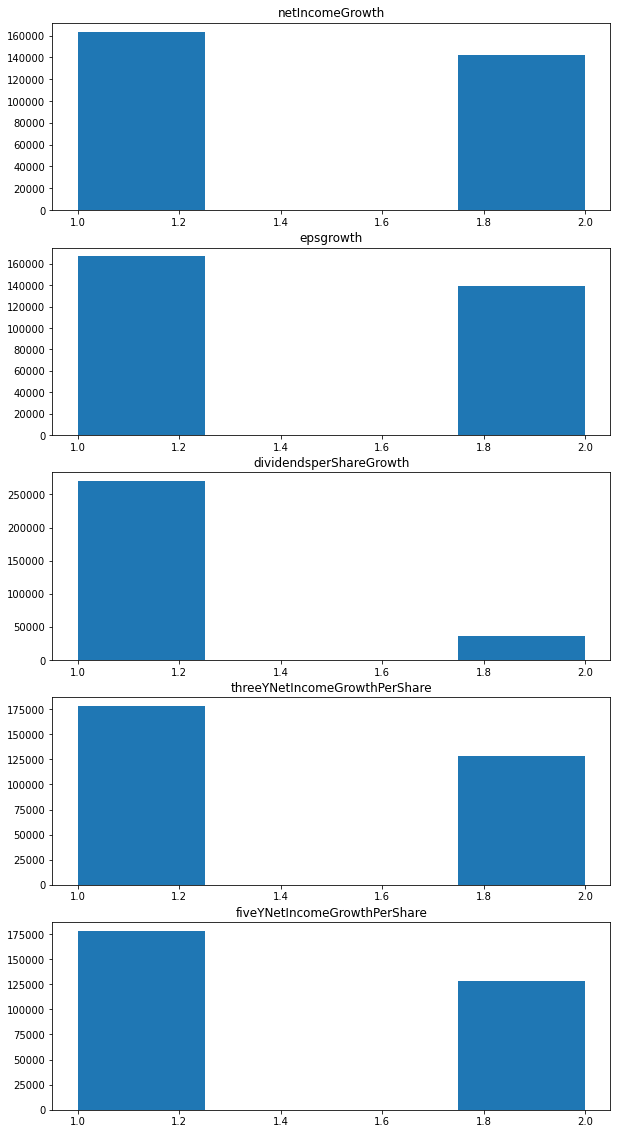

In [52]:
# --- Classification of rate 2
########## Subject to review ############

def growth_2(n):
    if type(n) == float:
        if n <= 0.01724725:
            return 1
        else:
            return 2
    else:
        return n

growth_df_cla_2 = growth_df.applymap(growth_2)

# --- Distribution of data

fig, axs = plt.subplots(5)
fig.set_size_inches(10, 20)
k = 0
for i in y_axis:
    axs[k].hist(growth_df_cla_2[i], bins = 4)
    axs[k].set_title(i)
    k += 1
plt.show()

In [54]:
split(combined)

for i in [lgr, tree, forest, ada, knn]:
    predict(i)

Accuracy score for LogisticRegression(max_iter=100000000, n_jobs=-2): 0.3797673789559102.
Accuracy score for DecisionTreeClassifier(): 0.34996280768190424.
Accuracy score for RandomForestClassifier(): 0.42652826616175277.
Accuracy score for AdaBoostClassifier(): 0.39672369488774684.
Accuracy score for KNeighborsClassifier(): 0.34960779010008114.


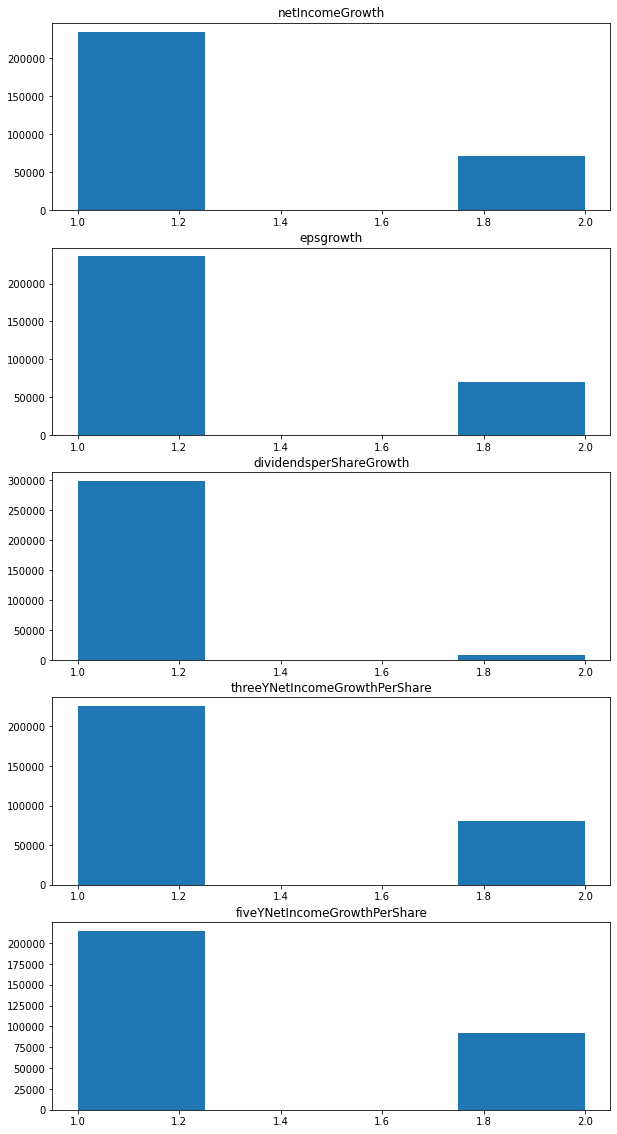

In [126]:
# --- Classification of rate 3
########## Subject to review ############

def growth_3(n):
    if type(n) == float:
        if n <= 0.5:
            return 1
        else:
            return 2
    else:
        return n

growth_df_cla_3 = growth_df.applymap(growth_3)

# --- Distribution of data

fig, axs = plt.subplots(5)
fig.set_size_inches(10, 20)
k = 0
for i in y_axis:
    axs[k].hist(growth_df_cla_3[i], bins = 4)
    axs[k].set_title(i)
    k += 1
plt.show()

In [127]:
split(combined)

for i in [lgr, tree, forest, ada, knn]:
    predict(i)

Accuracy score for LogisticRegression(max_iter=100000000, n_jobs=-2): 0.3797673789559102.
Accuracy score for DecisionTreeClassifier(): 0.34864417094941846.
Accuracy score for RandomForestClassifier(): 0.4266466053556938.
Accuracy score for AdaBoostClassifier(): 0.39672369488774684.
Accuracy score for KNeighborsClassifier(): 0.34960779010008114.


In [32]:
# --- Try linear regression instead

reg = pd.merge(figures, growth_df, on=['symbol', 'quarter'])

# --- Shifting one quarter back for prediction purpose
reg.insert(2, 'quarter_pred', reg['quarter'] - 1)
reg_2 = reg[['symbol','quarter_pred']+y_axis]
reg_2 = reg_2.rename({'quarter_pred': 'quarter'}, axis = 1)
reg = pd.merge(reg, reg_2, on=['symbol', 'quarter'])
reg = reg.drop('quarter_pred', axis=1)
reg.head()

,symbol,netIncome,depreciationAndAmortization,deferredIncomeTax,stockBasedCompensation,accountsReceivables,inventory,accountsPayables,otherWorkingCapital,otherNonCashItems,...,netIncomeGrowth_x,epsgrowth_x,dividendsperShareGrowth_x,threeYNetIncomeGrowthPerShare_x,fiveYNetIncomeGrowthPerShare_x,netIncomeGrowth_y,epsgrowth_y,dividendsperShareGrowth_y,threeYNetIncomeGrowthPerShare_y,fiveYNetIncomeGrowthPerShare_y
0,CMCSA,3.380000e+09,3.252000e+09,-326000000.0,271000000.0,0.0,0.0,0.0,5.240000e+08,91000000.0,...,0.674096,0.672761,-0.004576,-0.767501,0.858378,-0.015089,-0.010687,0.022359,0.094183,0.673132
1,CMCSA,2.019000e+09,3.320000e+09,-140000000.0,301000000.0,0.0,0.0,0.0,-2.142000e+09,254000000.0,...,-0.324297,-0.319870,0.013258,-0.202413,0.105891,0.674096,0.672761,-0.004576,-0.767501,0.858378
2,CMCSA,2.988000e+09,3.264000e+09,36000000.0,323000000.0,0.0,0.0,0.0,-9.600000e+08,125000000.0,...,0.391709,0.394736,0.078077,0.237213,0.536314,-0.324297,-0.319870,0.013258,-0.202413,0.105891
3,CMCSA,2.147000e+09,3.264000e+09,-120000000.0,298000000.0,0.0,0.0,0.0,-3.516000e+09,227000000.0,...,-0.320999,-0.320265,0.022004,-0.126708,0.154534,0.391709,0.394736,0.078077,0.237213,0.536314
4,CMCSA,3.162000e+09,3.177000e+09,95000000.0,231000000.0,0.0,0.0,0.0,-4.900000e+09,107000000.0,...,-0.017097,-0.017732,0.001444,0.338443,0.843036,-0.320999,-0.320265,0.022004,-0.126708,0.154534


In [43]:
def split(n):

    test = n[n['quarter'] >= 69]
    train = n[n['quarter'] < 69]

    X_test = test.iloc[:, 1:20]
    X_train = train.iloc[:, 1:20]

    scaler = StandardScaler()

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    y_test = test['netIncomeGrowth_y']
    y_train = train['netIncomeGrowth_y']

def predict(n):
    n.fit(X_train, y_train)
    y_pred = n.predict(X_test)
    print (f'R2 score for {n}: {r2_score(y_test, y_pred)}.')

In [44]:
split(reg)
lin = LinearRegression()
predict(lin)

R2 score for LinearRegression(): -0.0009248051161419024.


In [55]:
# --- Use ratio approach
ratio_df.head()

,Unnamed: 0,symbol,date,period,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,...,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue,quarter,year
0,0,CMCSA,2021-03-31,1,0.955438,0.841777,0.485216,147.395332,0.0,36.344054,...,47.049056,32.049931,32.049931,-17.455952,9.131373,0.004347,47.118783,2.683435,81,2021
1,1,CMCSA,2020-12-31,4,0.928636,0.805876,0.407696,151.042659,0.0,37.243395,...,157.601046,47.605393,47.605393,0.263889,8.662711,0.004391,55.651505,2.616434,80,2020
2,2,CMCSA,2020-09-30,3,0.927417,0.813832,0.464471,147.389550,0.0,36.342629,...,92.499786,40.499620,40.499620,-0.819628,8.292809,0.004997,48.797840,2.417833,79,2020
3,3,CMCSA,2020-06-30,2,0.966251,0.849429,0.489893,157.404807,0.0,38.812144,...,30.100714,20.777607,20.777607,0.380639,7.572459,0.005853,34.187316,2.117924,78,2020
4,4,CMCSA,2020-03-31,1,0.872609,0.699855,0.308551,148.145364,0.0,36.528994,...,47.739087,27.254887,27.254887,-0.577117,5.965368,0.006155,31.270757,1.917452,77,2020


In [91]:
ratio_df = pd.read_csv('data/ratio_df.csv')

In [92]:
drop = ['date', 'Unnamed: 0', 'period','daysOfSalesOutstanding','daysOfInventoryOutstanding','operatingCycle','daysOfPayablesOutstanding','cashConversionCycle','year']

ratio = ratio_df.drop(drop, axis=1)

In [85]:
ratio.iloc[0]

symbol                                     CMCSA
currentRatio                            0.955438
quickRatio                              0.841777
cashRatio                               0.485216
grossProfitMargin                       0.672156
operatingProfitMargin                   0.185223
pretaxProfitMargin                      0.162139
netProfitMargin                         0.122367
effectiveTaxRate                        0.253684
returnOnAssets                         0.0119528
returnOnEquity                           0.03596
returnOnCapitalEmployed                0.0203432
netIncomePerEBT                         0.754704
ebtPerEbit                              0.875372
ebitPerRevenue                          0.185223
debtRatio                               0.662132
debtEquityRatio                          1.99202
longTermDebtToCapitalization            0.516607
totalDebtToCapitalization               0.528372
interestCoverage                          4.9499
cashFlowToDebtRatio 

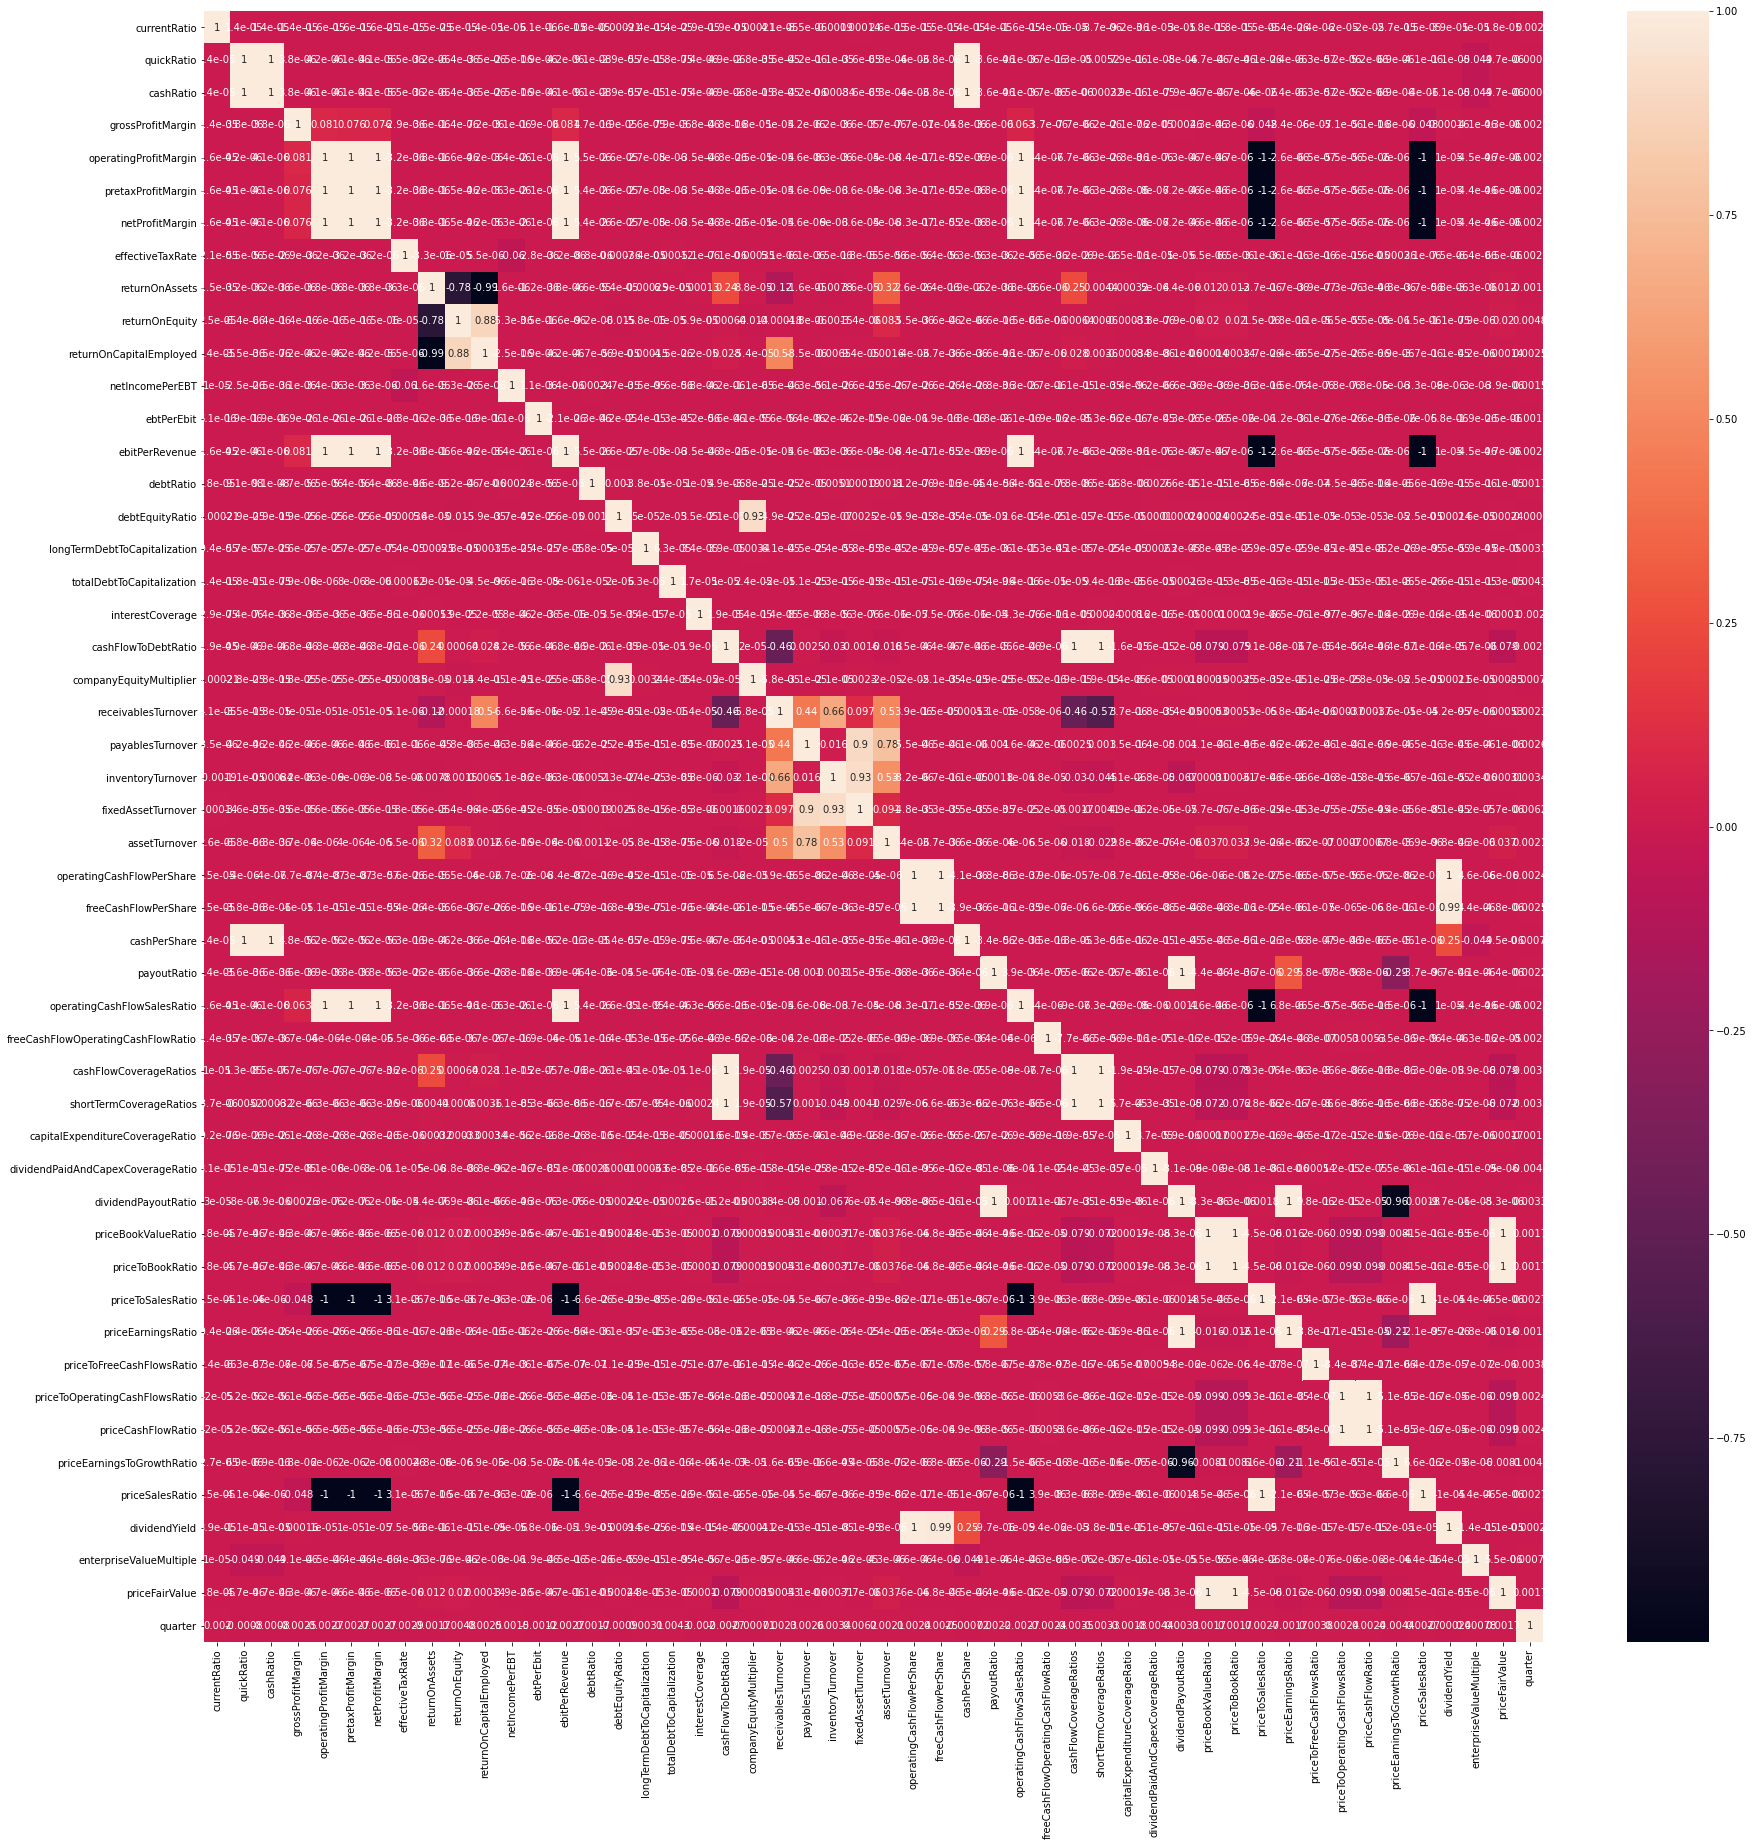

In [65]:
plt.figure(figsize=(30,30))
sns.heatmap(ratio.corr(), annot=True)
plt.show()

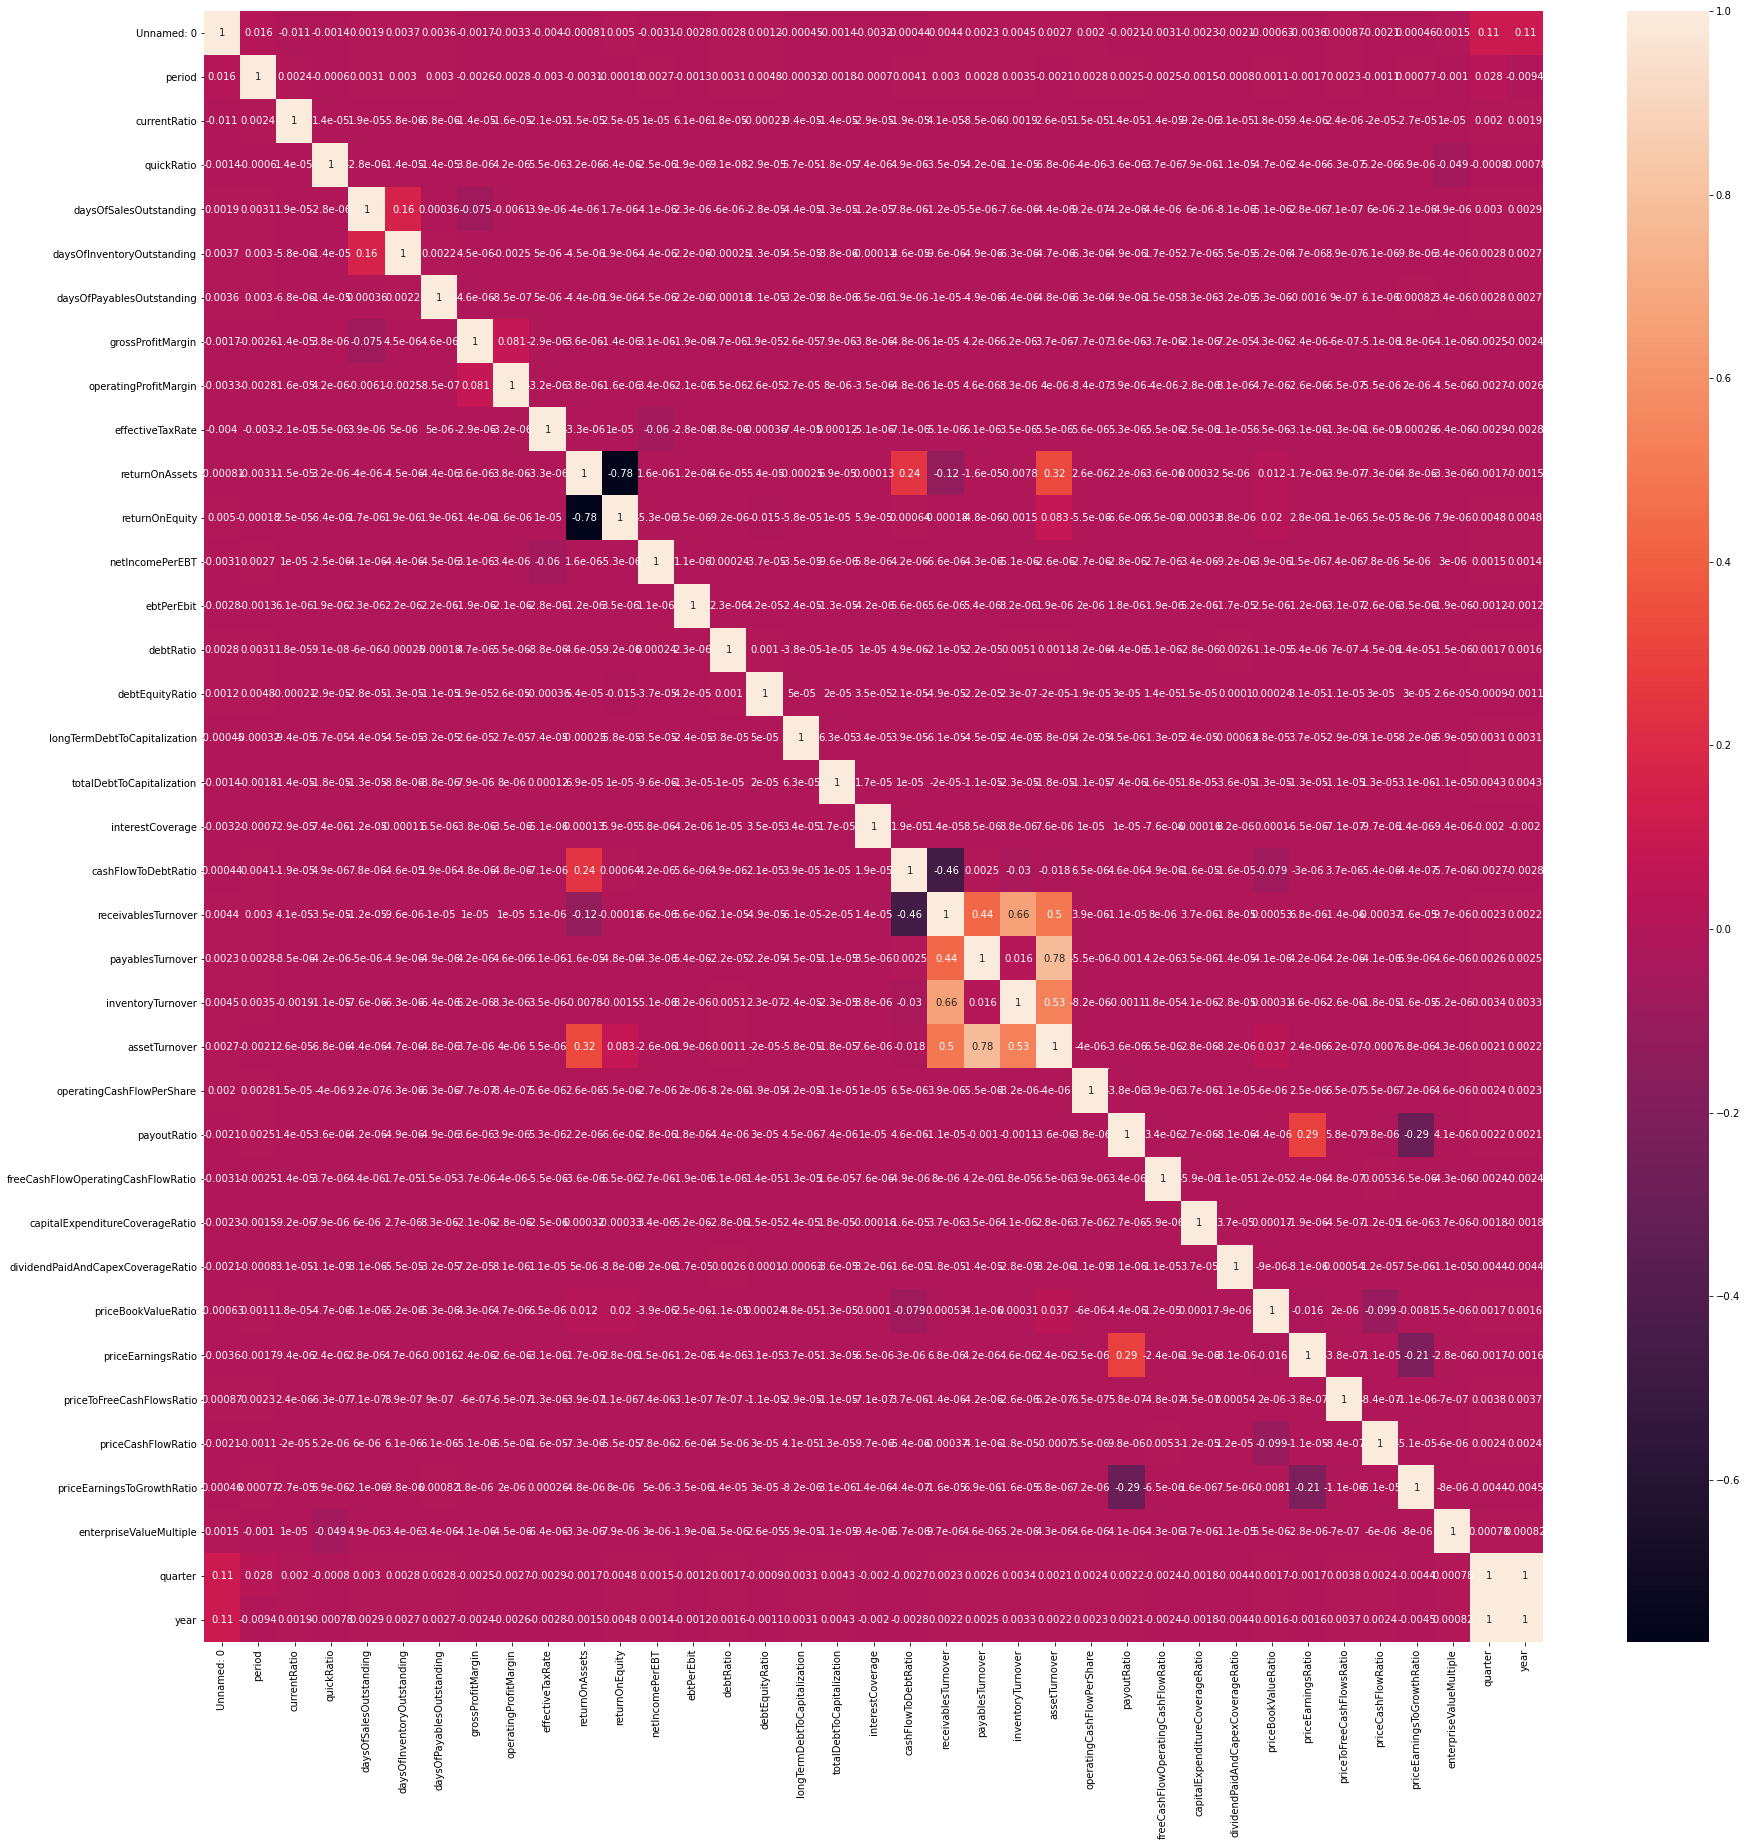

In [93]:
drop2 = ['cashRatio', 'pretaxProfitMargin', 'netProfitMargin', 'operatingCycle',  'cashConversionCycle', 'fixedAssetTurnover', 'priceToSalesRatio', 'cashFlowCoverageRatios', 'priceToOperatingCashFlowsRatio', 'freeCashFlowPerShare', 'priceSalesRatio', 'priceToBookRatio', 'priceSalesRatio', 'priceFairValue', 'cashPerShare', 'returnOnCapitalEmployed', 'companyEquityMultiplier', 'ebitPerRevenue',  'dividendYield', 'shortTermCoverageRatios', 'operatingCashFlowSalesRatio', 'dividendPayoutRatio']
ratio2 = ratio_df.drop(drop2, axis=1)
plt.figure(figsize=(30,30))
sns.heatmap(ratio2.corr(), annot=True)
plt.show()


In [94]:
ratio2.isnull().sum()

Unnamed: 0                                 0
symbol                                     0
date                                       0
period                                     0
currentRatio                           18072
quickRatio                             18072
daysOfSalesOutstanding                 12917
daysOfInventoryOutstanding             76004
daysOfPayablesOutstanding              76004
grossProfitMargin                      12917
operatingProfitMargin                  12917
effectiveTaxRate                       20570
returnOnAssets                           209
returnOnEquity                          1484
netIncomePerEBT                        20570
ebtPerEbit                             41300
debtRatio                                209
debtEquityRatio                         1484
longTermDebtToCapitalization           75277
totalDebtToCapitalization             160238
interestCoverage                      107312
cashFlowToDebtRatio                    75682
receivable

In [99]:
criteria = ['symbol', 'quarter', 'currentRatio',  'quickRatio', 'grossProfitMargin',  'operatingProfitMargin', 'returnOnAssets', 'returnOnEquity', 'netIncomePerEBT',  'ebtPerEbit',  'debtRatio',  'debtEquityRatio', 'assetTurnover', 'operatingCashFlowPerShare', 'payoutRatio',  'freeCashFlowOperatingCashFlowRatio']
price = ['priceBookValueRatio', 'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceCashFlowRatio', 'priceEarningsToGrowthRatio']
ratio3 = ratio2[criteria]
ratio3 = ratio3[ratio3['quarter']>=-3]
ratio3.head()

,symbol,quarter,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,netIncomePerEBT,ebtPerEbit,debtRatio,debtEquityRatio,assetTurnover,operatingCashFlowPerShare,payoutRatio,freeCashFlowOperatingCashFlowRatio
0,CMCSA,81,0.955438,0.841777,0.672156,0.185223,0.011953,0.035960,0.754704,0.875372,0.662132,1.992017,0.097680,1.688303,0.324422,0.681202
1,CMCSA,80,0.928636,0.805876,0.659376,0.141403,0.012342,0.036844,0.765399,1.127106,0.665030,1.985339,0.101172,1.100716,0.311834,0.302063
2,CMCSA,79,0.927417,0.813832,0.664539,0.159643,0.007507,0.023056,0.728881,0.679588,0.674385,2.071108,0.094936,1.142233,0.524022,0.437835
3,CMCSA,78,0.966251,0.849429,0.712545,0.195952,0.011234,0.035240,0.755499,0.851087,0.681210,2.136866,0.089162,1.876058,0.351740,0.690270
4,CMCSA,77,0.872609,0.699855,0.688038,0.182344,0.008182,0.025935,0.734268,0.602638,0.684541,2.169987,0.101398,1.261425,0.455054,0.570913


In [100]:
ratio3.isnull().sum()

symbol                                    0
quarter                                   0
currentRatio                          13925
quickRatio                            13925
grossProfitMargin                     12658
operatingProfitMargin                 12658
returnOnAssets                          208
returnOnEquity                         1476
netIncomePerEBT                       13614
ebtPerEbit                            35471
debtRatio                               208
debtEquityRatio                        1476
assetTurnover                           208
operatingCashFlowPerShare              2278
payoutRatio                            1203
freeCashFlowOperatingCashFlowRatio     2291
dtype: int64

In [101]:
ratio4 = ratio3.dropna()
ratio4.isnull().sum()

symbol                                0
quarter                               0
currentRatio                          0
quickRatio                            0
grossProfitMargin                     0
operatingProfitMargin                 0
returnOnAssets                        0
returnOnEquity                        0
netIncomePerEBT                       0
ebtPerEbit                            0
debtRatio                             0
debtEquityRatio                       0
assetTurnover                         0
operatingCashFlowPerShare             0
payoutRatio                           0
freeCashFlowOperatingCashFlowRatio    0
dtype: int64

In [103]:
ratio4.describe()

,quarter,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,netIncomePerEBT,ebtPerEbit,debtRatio,debtEquityRatio,assetTurnover,operatingCashFlowPerShare,payoutRatio,freeCashFlowOperatingCashFlowRatio
count,193636.000000,1.936360e+05,1.936360e+05,1.936360e+05,1.936360e+05,193636.000000,1.936360e+05,193636.000000,1.936360e+05,193636.000000,193636.000000,193636.000000,1.936360e+05,1.936360e+05,1.936360e+05
mean,47.517094,4.244217e+01,2.605604e+04,-3.370305e+11,-8.729688e+12,-0.147020,-1.122452e+01,3.228980,-3.997586e+09,0.740533,1.985355,4.177263,-8.153827e+02,5.149771e+05,-6.684254e+00
std,23.508346,8.749618e+03,1.137222e+07,1.483061e+14,3.545461e+15,8.408590,4.697707e+03,1142.388821,3.784205e+12,55.920070,260.293872,1036.749646,3.510033e+05,2.250111e+08,3.259385e+03
min,-3.000000,-3.269143e+03,-6.641643e+04,-6.526073e+16,-1.555000e+18,-1740.464977,-2.066667e+06,-48273.504274,-1.341892e+15,-47.862069,-29872.125000,-18060.799502,-1.526645e+08,-1.080950e+04,-1.434135e+06
25%,29.000000,1.206132e+00,7.242225e-01,2.097161e-01,1.378895e-03,-0.003837,-7.545357e-03,0.626673,7.154472e-01,0.336318,0.424836,0.091223,-2.631527e-03,0.000000e+00,4.904493e-01
50%,52.000000,1.919943e+00,1.247215e+00,3.698647e-01,8.096758e-02,0.008792,2.131345e-02,0.745391,9.502678e-01,0.522729,0.984537,0.186744,3.592665e-01,0.000000e+00,8.435456e-01
75%,68.000000,3.229895e+00,2.306006e+00,5.873611e-01,1.733659e-01,0.020739,4.575883e-02,0.997922,1.031879e+00,0.686811,1.908484,0.315499,1.052003e+00,2.517406e-01,1.000000e+00
max,82.000000,3.547710e+06,5.004094e+09,3.367666e+06,5.834529e+07,743.697767,1.089659e+04,500106.000000,9.203665e+14,24307.000000,87701.500000,356315.638864,1.287739e+07,9.901160e+10,1.289353e+04


In [117]:
ratio_comb = pd.merge(ratio4, growth_df, on=['symbol', 'quarter'])

# --- Shifting one quarter back for prediction purpose
ratio_comb.insert(2, 'quarter_pred', ratio_comb['quarter'] - 1)
ratio_comb_2 = ratio_comb[['symbol','quarter_pred']+y_axis]
ratio_comb_2 = ratio_comb_2.rename({'quarter_pred': 'quarter'}, axis = 1)
ratio_comb = pd.merge(ratio_comb, ratio_comb_2, on=['symbol', 'quarter'])
ratio_comb = ratio_comb.drop('quarter_pred', axis=1)
ratio_comb.head()

ratio_comb.iloc[0]

symbol                                     CMCSA
quarter                                       80
currentRatio                            0.928636
quickRatio                              0.805876
grossProfitMargin                       0.659376
operatingProfitMargin                   0.141403
returnOnAssets                         0.0123417
returnOnEquity                         0.0368441
netIncomePerEBT                         0.765399
ebtPerEbit                               1.12711
debtRatio                                0.66503
debtEquityRatio                          1.98534
assetTurnover                           0.101172
operatingCashFlowPerShare                1.10072
payoutRatio                             0.311834
freeCashFlowOperatingCashFlowRatio      0.302063
netIncomeGrowth_x                       0.674096
epsgrowth_x                             0.672761
dividendsperShareGrowth_x            -0.00457588
threeYNetIncomeGrowthPerShare_x        -0.767501
fiveYNetIncomeGrowth

In [123]:
def split(n):

    test = n[n['quarter'] >= 69]
    train = n[n['quarter'] < 69]

    X_test = test.iloc[:, 2:16]
    X_train = train.iloc[:, 2:16]

    scaler = StandardScaler()

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    y_test = test['netIncomeGrowth_y']
    y_train = train['netIncomeGrowth_y']

def predict(n):
    n.fit(X_train, y_train)
    y_pred = n.predict(X_test)
    print (f'Accuracy score for {i}: {accuracy_score(y_test, y_pred)}.')

In [121]:
split(ratio_comb)
print(len(X_train), len(X_test))

236995 59152


In [124]:
for i in [lgr, tree, forest, ada, knn]:
    predict(i)

Accuracy score for LogisticRegression(max_iter=100000000, n_jobs=-2): 0.3797673789559102.
Accuracy score for DecisionTreeClassifier(): 0.35001352447930756.
Accuracy score for RandomForestClassifier(): 0.425327968623208.
Accuracy score for AdaBoostClassifier(): 0.39672369488774684.
Accuracy score for KNeighborsClassifier(): 0.34960779010008114.
